# DualAQD: Dual Accuracy-quality-driven Prediction Intervals

We created a synthetic dataset with varying PI widths that consists of a sinusoid with Gaussian noise.
Specifically, the dataset contains 1000 points which were generated using the equation $y = 5 \, \text{cos}(x) + 10 + \epsilon$, where $x \in [-5, 5]$ and $\epsilon$ is a Gaussian noise whose amplitude depends on $x$: $\epsilon = (2 \, \text{cos}(1.2 \, x) + 2) \, g$ and $g \sim \mathcal{N}(0, 1)$.  

For these experiments, we used a feed-forward neural network (FNN) with two hidden layers with 100 nodes each.
$5\times2$-fold cross-validation was used to train and evaluate all networks.

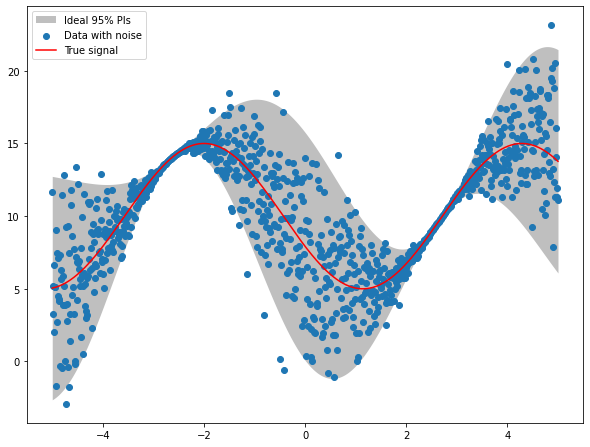

In [1]:
import utils
import pandas as pd
from scipy import stats
from PIGenerator import PIGenerator
import matplotlib.pyplot as plt
name = 'Synth'    # Define the name of the dataset 
crossval = '5x2'  # We'll use 5x2 cross-validation for all methods 
_, _ = utils.create_synth_data(plot=True)  # Plot the dataset

**Method 1: DualAQD**

The target-estimation network $f$ is trained to generate accurate estimates, so that its parameteres $\theta_f$ are obtained as:

$\boldsymbol{\theta}_f = \; \underset{\boldsymbol{\theta_f}}{\text{argmin}} \ MSE_{est}.$

The PI-generation NN is trained using our DualAQD loss function:

$Loss_{DualAQD} = MPIW_{penalty} + \lambda \, C$

where:
* $MPIW_{penalty} = \frac{1}{N} \sum_{i=1}^{N} (|\hat{y}^u_i - \hat{y}_i| + |\hat{y}_i - \hat{y}^\ell_i|)$ is a penalty 
term that quantifies the width of the PI as the sum of the distance between the upper bound and the target estimate and 
the distance between the lower bound and the target estimate,
* $C = e^{\xi - d_u} + e^{\xi - d_\ell} + e^{-\sum_{i=1}^N(\hat{y}^u_i - \hat{y}^\ell_i) / N}$ is a constraint that assures
  PI interity. Here, $d_u = \sum_{i=1}^N(\hat{y}^u_i - \hat{y}_i) / N$ and $d_\ell = \sum_{i=1}^N(\hat{y}_i - \hat{y}^\ell_i) / N$
  are the mean differences between the PI bounds and the target estimates, and 
$\xi = \text{max}(| \hat{\textbf{Y}}^b - \textbf{Y}^b|)$ ($\hat{\textbf{Y}}^b = \{ \hat{y}_1, \dots , \hat{y}_N \}$) is
the maximum distance between a target estimate and its corresponding target value within the batch
* $\lambda$ is a self-adaptive coefficient that controls the relative importance of both objectives.

Note that $\lambda$ is adapted throughout the learning process automatically as follows:

$\lambda^{(t)} = \lambda^{(t - 1)} + \alpha \cdot \mathcal{C},$

where $\lambda^{(t)}$ denotes the value of the coefficient $\lambda$ at the $t$-th iteration (we consider that $\lambda^{(0)}=1$), and $\alpha$ is a tunable learning rate.

In this experiment, we use $\alpha=0.01$.

Loading model...
Using 5x2 cross-validation for this dataset

******************************
Training fold: 1
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 4.977938243838673 Val PICP: 0.9500000476837158 Val MPIW: 7.300964832305908

******************************
Training fold: 2
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.293192449344713 Val PICP: 0.9540000557899475 Val MPIW: 7.059872627258301

******************************
Training fold: 3
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.264780704436265 Val PICP: 0.9500000476837158 Val MPIW: 7.115170478820801

******************************
Training fold: 4
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.530183065165466 Val PICP: 0.9500000476837158 Val MPIW: 7.458146572113037

******************************
Training fold: 5
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.366049390084778 Val PICP: 0.950000047

100%|██████████| 1000/1000 [09:48<00:00,  1.70it/s]


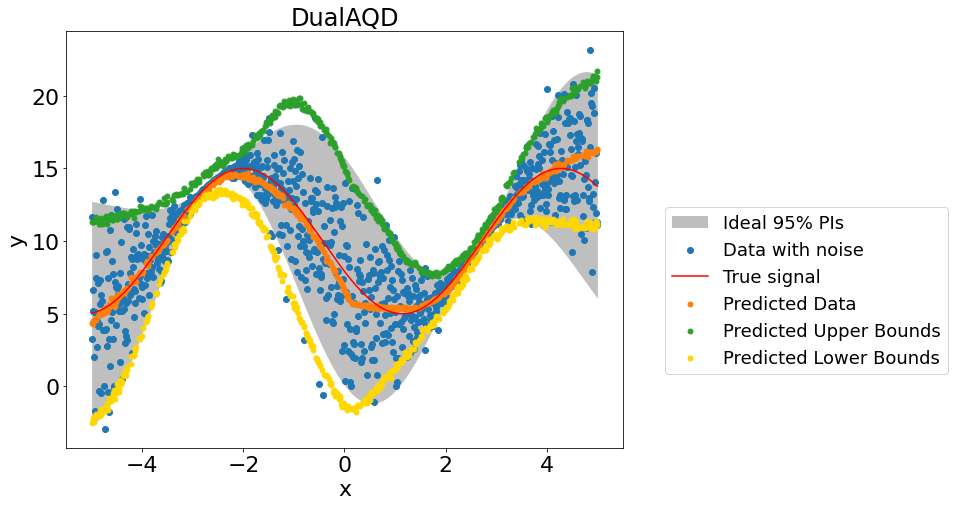

In [2]:
predictor = PIGenerator(dataset=name, method='DualAQD')
cvmse1, cvmpiw1, cvpicp1 = predictor.train(crossval='5x2', batch_size=8, epochs=1000, alpha_=0.01, printProcess=False)

**Method 2: QD+**

Train an ensemble of 5 FNNs using the [QD+](https://arxiv.org/abs/2007.09670) loss function:

$Loss_{QD+} = (1 - \lambda_1) (1 - \lambda_2) MPIW_{capt}  + \lambda_1 (1 - \lambda_2) \max(0, (1 - \alpha) - PICP) ^ 2 + \lambda_2 \, MSE_{est} + \frac{\xi}{N} \sum_{i=1}^N \left[ \max(0, (\hat{y}^u_i - \hat{y}_i) + \max(0, (\hat{y}_i - \hat{y}^\ell_i) \right]$

The PIs generated by the ensemble are aggregated using a split normal mixture.

In this experiment, we use $\lambda_1=0.6$ and $\lambda_2=0.2$.

Loading model...
Using 5x2 cross-validation for this dataset

******************************
Training fold: 1
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.194384661980954 Val PICP: 0.956000030040741 Val MPIW: 8.34195327758789

******************************
Training fold: 2
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.311679408627856 Val PICP: 0.9500000476837158 Val MPIW: 8.805007934570312

******************************
Training fold: 3
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.2989268293488205 Val PICP: 0.9480000734329224 Val MPIW: 8.743640899658203

******************************
Training fold: 4
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.6265960924016385 Val PICP: 0.9460000395774841 Val MPIW: 8.520522117614746

******************************
Training fold: 5
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.520623931732606 Val PICP: 0.952000021

100%|██████████| 1000/1000 [10:33<00:00,  1.58it/s]


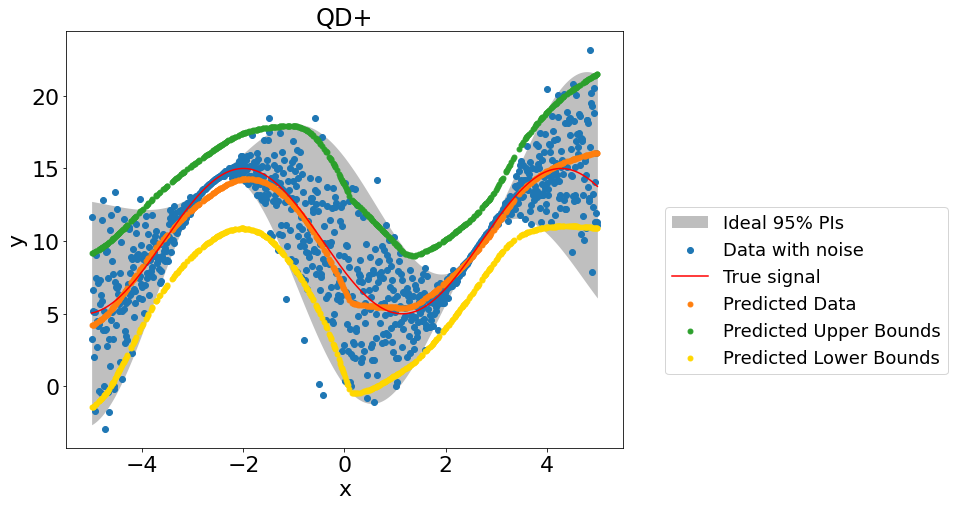

In [3]:
predictor = PIGenerator(dataset=name, method='QD+')
cvmse2, cvmpiw2, cvpicp2 = predictor.train(crossval='5x2', batch_size=8, epochs=1000, beta_=[0.6, 0.2], 
                                           printProcess=False)

**Method 3: QD-Ens**  

Train an ensemble of 5 FNNs using the [QD-Ens](https://arxiv.org/abs/1802.07167) loss function:

$Loss_{QD} = MPIW_{capt}  + \delta \, \frac{N}{\alpha (1 - \alpha)} \max(0, (1 - \alpha) - PICP) ^ 2$

In this experiment, we use $\delta=0.055$.

Loading model...
Using 5x2 cross-validation for this dataset

******************************
Training fold: 1
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 4.944525058393043 Val PICP: 0.9520000219345093 Val MPIW: 9.9015531539917

******************************
Training fold: 2
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.113900830886636 Val PICP: 0.956000030040741 Val MPIW: 10.240141868591309

******************************
Training fold: 3
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.395296692807103 Val PICP: 0.9280000329017639 Val MPIW: 8.796696662902832

******************************
Training fold: 4
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.558931883058744 Val PICP: 0.9200000166893005 Val MPIW: 8.391230583190918

******************************
Training fold: 5
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.399255275171168 Val PICP: 0.94000005722

100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


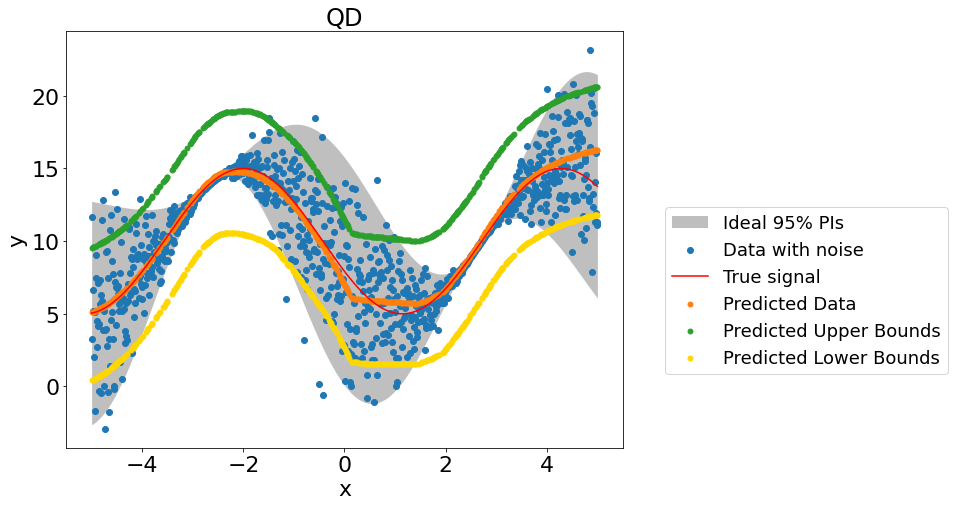

In [4]:
predictor = PIGenerator(dataset=name, method='QD')
cvmse3, cvmpiw3, cvpicp3 = predictor.train(crossval='5x2', batch_size=8, epochs=1000, beta_=0.055, printProcess=False)

**Method 4: MC-Dropout-PI**  

Train a FNN using the MSE loss function. PIs are obtained by quantifying the model uncertainty through 
[MC-Dropout](https://arxiv.org/abs/1709.01907), coupled with estimating the data noise variance through an independent 
held-out validation set.

Loading model...
Using 5x2 cross-validation for this dataset

******************************
Training fold: 1
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 4.993737331983181 Val PICP: 0.9320000410079956 Val MPIW: 9.111411094665527

******************************
Training fold: 2
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.296218463273777 Val PICP: 0.9180000424385071 Val MPIW: 9.30754280090332

******************************
Training fold: 3
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.248641927708923 Val PICP: 0.9240000247955322 Val MPIW: 9.21928596496582

******************************
Training fold: 4
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.521086120008127 Val PICP: 0.9360000491142273 Val MPIW: 9.531404495239258

******************************
Training fold: 5
******************************
PERFORMANCE AFTER AGGREGATION:
Val MSE: 5.318807654997651 Val PICP: 0.93600004911

100%|██████████| 1000/1000 [03:37<00:00,  4.61it/s]


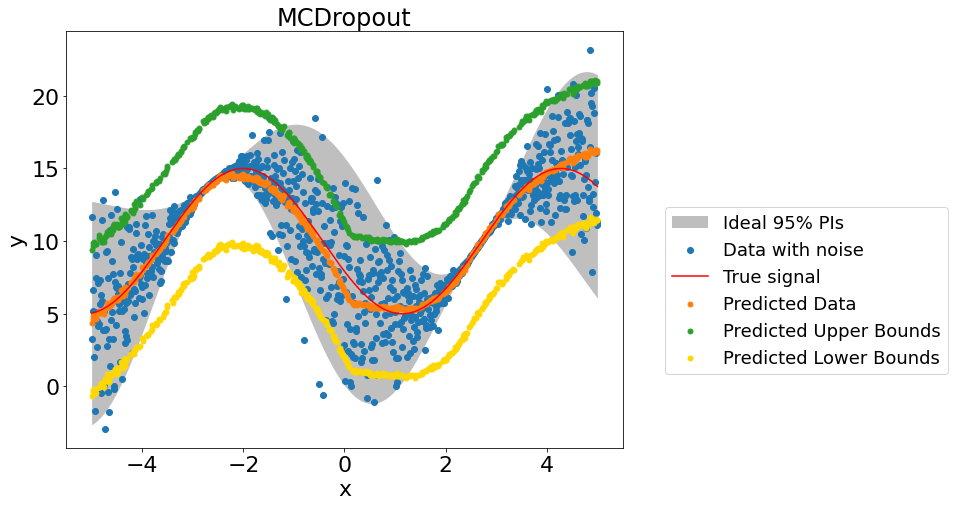

In [5]:
predictor = PIGenerator(dataset=name, method='MCDropout')
cvmse4, cvmpiw4, cvpicp4 = predictor.train(crossval='5x2', batch_size=8, epochs=1000, printProcess=False)

**Method Comparison**

We perform a paired *t*-test at the 0.05 significance level and plot box plots for each metric (MPIW, MSE, and PICP).  

Metric: mpiw
AQD vs. QD+. p-value = 0.0003251523973520653
AQD vs. QD. p-value = 7.427948560061278e-05
AQD vs. MC-Dropout-PI. p-value = 1.271615420865516e-07
Metric: mse
AQD vs. QD+. p-value = 0.012962622611674636
AQD vs. QD. p-value = 0.9154708209900889
AQD vs. MC-Dropout-PI. p-value = 0.8071234747975858
Metric: picp
AQD vs. QD+. p-value = 0.13405113222237855
AQD vs. QD. p-value = 0.01203638581036227
AQD vs. MC-Dropout-PI. p-value = 2.596112451083136e-05


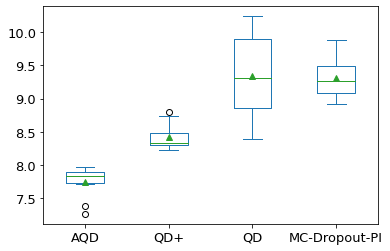

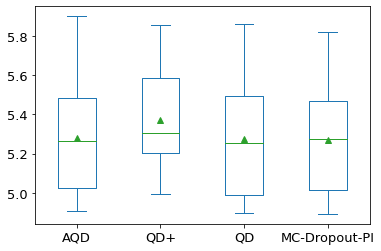

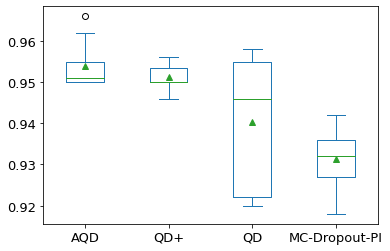

In [7]:
for metric in ['mpiw', 'mse', 'picp']:
    cvAQD = globals()['cv' + metric + '1']
    cvQDp = globals()['cv' + metric + '2']
    cvQD = globals()['cv' + metric + '3']
    cvMC = globals()['cv' + metric + '4']
    df = pd.DataFrame({'AQD': cvAQD, 'QD+': cvQDp, 'QD': cvQD, 'MC-Dropout-PI': cvMC})
    ax = df[['AQD', 'QD+', 'QD', 'MC-Dropout-PI']].plot(kind='box', showmeans=True)
    ax.tick_params(labelsize=9)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    # Perform t-test
    print('Metric: ' + metric)
    compqdp = stats.ttest_rel(df['AQD'], df['QD+'])
    print('AQD vs. QD+. p-value = ' + str(compqdp.pvalue))
    compqd = stats.ttest_rel(df['AQD'], df['QD'])
    print('AQD vs. QD. p-value = ' + str(compqd.pvalue))
    compmc = stats.ttest_rel(df['AQD'], df['MC-Dropout-PI'])
    print('AQD vs. MC-Dropout-PI. p-value = ' + str(compmc.pvalue))